# C4.5 Decision Tree Classifier for Iris Dataset

This notebook implements the C4.5 algorithm from scratch to classify iris flowers.

## Algorithm Overview:
- Uses **Gain Ratio** instead of Information Gain to reduce bias toward features with many values
- Handles both continuous and categorical features naturally
- Can handle missing values (simplified implementation)
- Improved version of ID3 with better splitting criteria

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from collections import Counter
import math

In [3]:
# Load and prepare the iris dataset
def load_iris_data():
    """Load and return iris dataset as pandas DataFrame"""
    iris = load_iris()
    
    # Create DataFrame with original continuous features
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['species'] = iris.target_names[iris.target]
    
    return df

# Load the data
iris_df = load_iris_data()
print("Iris Dataset Shape:", iris_df.shape)
print("\nFirst 5 rows:")
print(iris_df.head())
print("\nDataset Info:")
print(iris_df.info())
print("\nTarget distribution:")
print(iris_df['species'].value_counts())
print("\nFeature statistics:")
print(iris_df.describe())

Iris Dataset Shape: (150, 5)

First 5 rows:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  species  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4

In [4]:
# C4.5 Decision Tree Implementation
class C45DecisionTree:
    """Simple C4.5 Decision Tree implementation"""
    
    def __init__(self, max_depth=10, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.tree = None
        self.feature_names = None
    
    def entropy(self, labels):
        """Calculate entropy of a set of labels"""
        if len(labels) == 0:
            return 0
        
        # Count occurrences of each label
        counts = Counter(labels)
        total = len(labels)
        
        # Calculate entropy
        entropy = 0
        for count in counts.values():
            if count > 0:
                p = count / total
                entropy -= p * math.log2(p)
        
        return entropy
    
    def split_info(self, subsets):
        """Calculate split information (used in gain ratio)"""
        total_samples = sum(len(subset) for subset in subsets)
        if total_samples == 0:
            return 0
        
        split_info = 0
        for subset in subsets:
            if len(subset) > 0:
                p = len(subset) / total_samples
                split_info -= p * math.log2(p)
        
        return split_info
    
    def information_gain(self, data, target_col, feature_col, split_value=None):
        """Calculate information gain for a feature split"""
        # Calculate initial entropy
        initial_entropy = self.entropy(data[target_col])
        
        if split_value is None:
            # Categorical split - use unique values
            feature_values = data[feature_col].unique()
            subsets = [data[data[feature_col] == value] for value in feature_values]
        else:
            # Continuous split - use threshold
            left_subset = data[data[feature_col] <= split_value]
            right_subset = data[data[feature_col] > split_value]
            subsets = [left_subset, right_subset]
        
        # Calculate weighted entropy after split
        total_samples = len(data)
        weighted_entropy = 0
        
        for subset in subsets:
            if len(subset) > 0:
                weight = len(subset) / total_samples
                weighted_entropy += weight * self.entropy(subset[target_col])
        
        # Information gain = Initial entropy - Weighted entropy
        return initial_entropy - weighted_entropy, subsets
    
    def gain_ratio(self, data, target_col, feature_col, split_value=None):
        """Calculate gain ratio (information gain / split info)"""
        info_gain, subsets = self.information_gain(data, target_col, feature_col, split_value)
        split_information = self.split_info(subsets)
        
        # Avoid division by zero
        if split_information == 0:
            return 0
        
        return info_gain / split_information
    
    def find_best_split(self, data, target_col):
        """Find the best feature and split point using gain ratio"""
        best_gain_ratio = -1
        best_feature = None
        best_split_value = None
        best_subsets = None
        
        # Get feature columns (excluding target)
        feature_cols = [col for col in data.columns if col != target_col]
        
        # Try each feature
        for feature in feature_cols:
            feature_values = data[feature].values
            
            # Check if feature is continuous (numeric)
            if data[feature].dtype in ['int64', 'float64']:
                # For continuous features, try different thresholds
                unique_values = sorted(data[feature].unique())
                
                # Try midpoints between consecutive unique values
                for i in range(len(unique_values) - 1):
                    threshold = (unique_values[i] + unique_values[i + 1]) / 2
                    
                    # Calculate gain ratio for this threshold
                    gain_ratio = self.gain_ratio(data, target_col, feature, threshold)
                    
                    if gain_ratio > best_gain_ratio:
                        best_gain_ratio = gain_ratio
                        best_feature = feature
                        best_split_value = threshold
                        _, best_subsets = self.information_gain(data, target_col, feature, threshold)
            else:
                # For categorical features, use all unique values
                gain_ratio = self.gain_ratio(data, target_col, feature)
                
                if gain_ratio > best_gain_ratio:
                    best_gain_ratio = gain_ratio
                    best_feature = feature
                    best_split_value = None
                    _, best_subsets = self.information_gain(data, target_col, feature)
        
        return best_feature, best_split_value, best_subsets, best_gain_ratio
    
    def build_tree(self, data, target_col, depth=0):
        """Recursively build the decision tree"""
        # Base cases
        target_values = data[target_col].unique()
        
        # If all samples have same class, return leaf node
        if len(target_values) == 1:
            return target_values[0]
        
        # If max depth reached or not enough samples, return most common class
        if (depth >= self.max_depth or 
            len(data) < self.min_samples_split):
            return data[target_col].mode()[0]
        
        # Find best split using gain ratio
        best_feature, best_split_value, best_subsets, best_gain_ratio = self.find_best_split(data, target_col)
        
        # If no good split found, return most common class
        if best_feature is None or best_gain_ratio <= 0:
            return data[target_col].mode()[0]
        
        # Create tree node
        if best_split_value is not None:
            # Continuous feature split
            tree = {
                'feature': best_feature,
                'split_value': best_split_value,
                'type': 'continuous',
                'left': None,  # <= split_value
                'right': None,  # > split_value
                'gain_ratio': best_gain_ratio,
                'samples': len(data),
                'class_distribution': dict(data[target_col].value_counts())
            }
            
            # Check minimum samples per leaf
            if len(best_subsets[0]) >= self.min_samples_leaf:
                tree['left'] = self.build_tree(best_subsets[0], target_col, depth + 1)
            else:
                tree['left'] = data[target_col].mode()[0]
                
            if len(best_subsets[1]) >= self.min_samples_leaf:
                tree['right'] = self.build_tree(best_subsets[1], target_col, depth + 1)
            else:
                tree['right'] = data[target_col].mode()[0]
        else:
            # Categorical feature split
            tree = {
                'feature': best_feature,
                'type': 'categorical',
                'branches': {},
                'gain_ratio': best_gain_ratio,
                'samples': len(data),
                'class_distribution': dict(data[target_col].value_counts())
            }
            
            # Create branches for each value
            feature_values = data[best_feature].unique()
            for i, value in enumerate(feature_values):
                subset = best_subsets[i]
                if len(subset) >= self.min_samples_leaf:
                    tree['branches'][value] = self.build_tree(subset, target_col, depth + 1)
                else:
                    tree['branches'][value] = data[target_col].mode()[0]
        
        return tree
    
    def fit(self, X, y):
        """Train the decision tree"""
        # Combine features and target
        data = X.copy()
        data['target'] = y
        
        self.feature_names = list(X.columns)
        self.tree = self.build_tree(data, 'target')
        return self
    
    def predict_single(self, sample, tree=None):
        """Predict class for a single sample"""
        if tree is None:
            tree = self.tree
        
        # If tree is a leaf node (string), return the class
        if isinstance(tree, str):
            return tree
        
        # Navigate based on split type
        if tree['type'] == 'continuous':
            feature_value = sample[tree['feature']]
            if feature_value <= tree['split_value']:
                return self.predict_single(sample, tree['left'])
            else:
                return self.predict_single(sample, tree['right'])
        else:  # categorical
            feature_value = sample[tree['feature']]
            if feature_value in tree['branches']:
                return self.predict_single(sample, tree['branches'][feature_value])
            else:
                # If value not seen in training, return most common class from training
                # For simplicity, return the first available class
                return list(tree['branches'].values())[0]
    
    def predict(self, X):
        """Predict classes for multiple samples"""
        predictions = []
        for _, sample in X.iterrows():
            pred = self.predict_single(sample)
            predictions.append(pred)
        return predictions
    
    def print_tree(self, tree=None, indent="", side=""):
        """Print the decision tree structure"""
        if tree is None:
            tree = self.tree
        
        if isinstance(tree, str):
            print(f"{indent}{side}-> Class: {tree}")
            return
        
        if tree['type'] == 'continuous':
            print(f"{indent}{side}Feature: {tree['feature']} <= {tree['split_value']:.3f}")
            print(f"{indent}  Gain Ratio: {tree['gain_ratio']:.3f}, Samples: {tree['samples']}")
            print(f"{indent}  Class distribution: {tree['class_distribution']}")
            
            if tree['left'] is not None:
                self.print_tree(tree['left'], indent + "  ", "Left ")
            if tree['right'] is not None:
                self.print_tree(tree['right'], indent + "  ", "Right ")
        else:  # categorical
            print(f"{indent}{side}Feature: {tree['feature']}")
            print(f"{indent}  Gain Ratio: {tree['gain_ratio']:.3f}, Samples: {tree['samples']}")
            print(f"{indent}  Class distribution: {tree['class_distribution']}")
            
            for value, subtree in tree['branches'].items():
                print(f"{indent}  Value: {value}")
                self.print_tree(subtree, indent + "    ", "")

print("C4.5 Decision Tree class implemented successfully!")

C4.5 Decision Tree class implemented successfully!


In [5]:
# Split data into training and testing sets
X = iris_df.drop('species', axis=1)
y = iris_df['species']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nFeatures: {list(X.columns)}")
print(f"\nTraining set target distribution:")
print(y_train.value_counts())
print(f"\nTest set target distribution:")
print(y_test.value_counts())

Training set shape: (105, 4)
Test set shape: (45, 4)

Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

Training set target distribution:
species
versicolor    35
setosa        35
virginica     35
Name: count, dtype: int64

Test set target distribution:
species
virginica     15
versicolor    15
setosa        15
Name: count, dtype: int64


In [6]:
# Train the C4.5 Decision Tree
print("Training C4.5 Decision Tree...")

# Create and train the model
c45_tree = C45DecisionTree(max_depth=6, min_samples_split=2, min_samples_leaf=1)
c45_tree.fit(X_train, y_train)

print("Training completed!")
print("\n" + "="*60)
print("C4.5 DECISION TREE STRUCTURE:")
print("="*60)
c45_tree.print_tree()

Training C4.5 Decision Tree...
Training completed!

C4.5 DECISION TREE STRUCTURE:
Feature: petal length (cm) <= 2.450
  Gain Ratio: 1.000, Samples: 105
  Class distribution: {'versicolor': np.int64(35), 'setosa': np.int64(35), 'virginica': np.int64(35)}
  Left -> Class: setosa
  Right Feature: petal width (cm) <= 1.550
    Gain Ratio: 0.748, Samples: 70
    Class distribution: {'versicolor': np.int64(35), 'virginica': np.int64(35)}
    Left Feature: petal length (cm) <= 4.950
      Gain Ratio: 1.000, Samples: 34
      Class distribution: {'versicolor': np.int64(33), 'virginica': np.int64(1)}
      Left -> Class: versicolor
      Right -> Class: virginica
    Right Feature: petal length (cm) <= 4.850
      Gain Ratio: 0.236, Samples: 36
      Class distribution: {'virginica': np.int64(34), 'versicolor': np.int64(2)}
      Left Feature: sepal length (cm) <= 6.050
        Gain Ratio: 1.000, Samples: 2
        Class distribution: {'versicolor': np.int64(1), 'virginica': np.int64(1)}
      

In [7]:
# Make predictions on test set
print("Making predictions on test set...")

# Make predictions
y_pred = c45_tree.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Detailed classification report
print("\n" + "="*50)
print("CLASSIFICATION REPORT:")
print("="*50)
print(classification_report(y_test, y_pred))

# Show some example predictions
print("\n" + "="*50)
print("SAMPLE PREDICTIONS:")
print("="*50)
for i in range(min(8, len(X_test))):
    sample = X_test.iloc[i]
    actual = y_test.iloc[i]
    predicted = y_pred[i]
    
    print(f"Sample {i+1}:")
    print(f"  Sepal Length: {sample['sepal length (cm)']:.2f} cm")
    print(f"  Sepal Width:  {sample['sepal width (cm)']:.2f} cm")
    print(f"  Petal Length: {sample['petal length (cm)']:.2f} cm")
    print(f"  Petal Width:  {sample['petal width (cm)']:.2f} cm")
    print(f"  Actual: {actual}, Predicted: {predicted}")
    print(f"  {'✓ Correct' if actual == predicted else '✗ Wrong'}")
    print()

Making predictions on test set...

Test Accuracy: 0.9111

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.87      0.87      0.87        15
   virginica       0.87      0.87      0.87        15

    accuracy                           0.91        45
   macro avg       0.91      0.91      0.91        45
weighted avg       0.91      0.91      0.91        45


SAMPLE PREDICTIONS:
Sample 1:
  Sepal Length: 7.30 cm
  Sepal Width:  2.90 cm
  Petal Length: 6.30 cm
  Petal Width:  1.80 cm
  Actual: virginica, Predicted: virginica
  ✓ Correct

Sample 2:
  Sepal Length: 6.10 cm
  Sepal Width:  2.90 cm
  Petal Length: 4.70 cm
  Petal Width:  1.40 cm
  Actual: versicolor, Predicted: versicolor
  ✓ Correct

Sample 3:
  Sepal Length: 6.30 cm
  Sepal Width:  2.80 cm
  Petal Length: 5.10 cm
  Petal Width:  1.50 cm
  Actual: virginica, Predicted: virginica
  ✓ Correct

Sample 4:
  Sepal Length: 6.30 c


ALGORITHM COMPARISON
             Aspect                       ID3                          C4.5                          CART
Splitting Criterion          Information Gain                    Gain Ratio                 Gini Impurity
      Feature Types          Categorical only Both categorical & continuous Both categorical & continuous
     Missing Values               Not handled       Can handle (simplified)                    Can handle
        Overfitting      Prone to overfitting                Better pruning                  Good pruning
         Split Type          Multi-way splits            Multi-way & binary            Binary splits only
      Bias Handling Biased toward many values                  Reduces bias                   Less biased
Continuous Features   Requires discretization                Native support                Native support


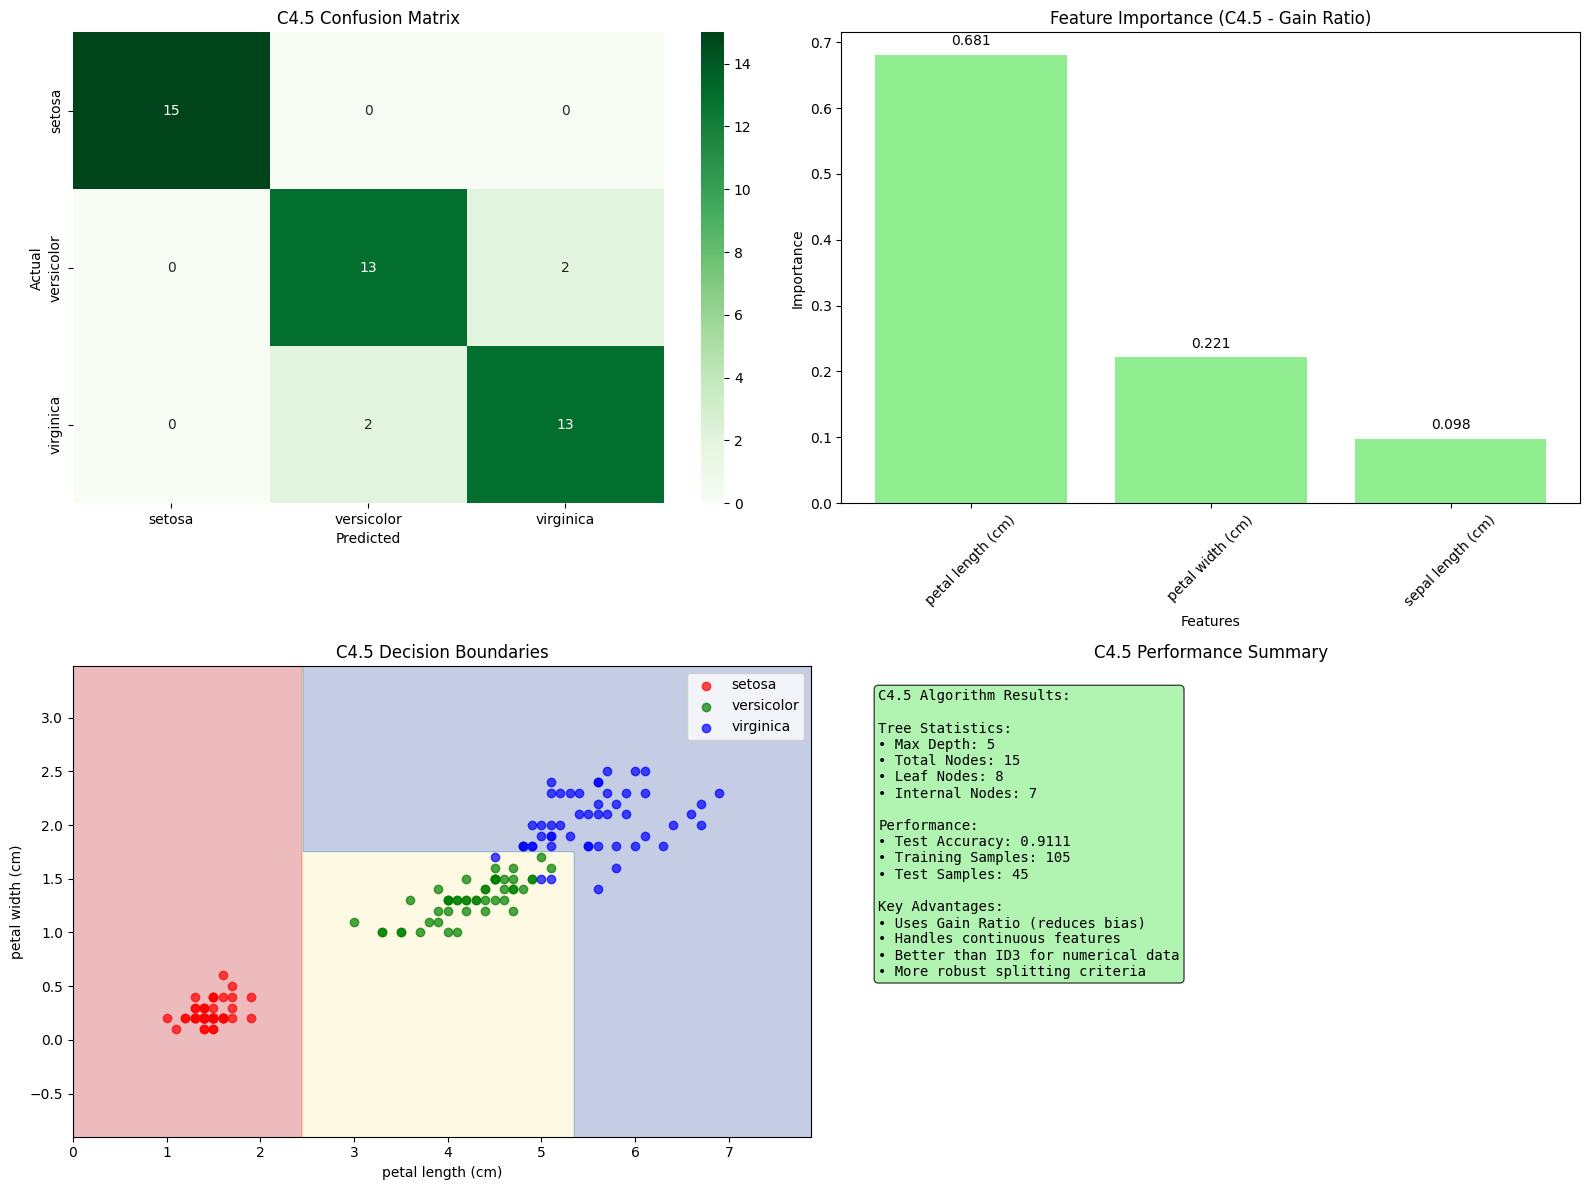


Final Results Summary:
Algorithm: C4.5 Decision Tree
Dataset: Iris (continuous features)
Test Accuracy: 0.9111
Tree Depth: 5
Total Nodes: 15
Leaf Nodes: 8
Most important feature: petal length (cm)
✓ C4.5 implementation completed successfully!


In [8]:
# Comparative Analysis: C4.5 vs ID3 vs CART
print("\n" + "="*60)
print("ALGORITHM COMPARISON")
print("="*60)

# Create comparison table
comparison_data = {
    'Aspect': [
        'Splitting Criterion',
        'Feature Types',
        'Missing Values',
        'Overfitting',
        'Split Type',
        'Bias Handling',
        'Continuous Features'
    ],
    'ID3': [
        'Information Gain',
        'Categorical only',
        'Not handled',
        'Prone to overfitting',
        'Multi-way splits',
        'Biased toward many values',
        'Requires discretization'
    ],
    'C4.5': [
        'Gain Ratio',
        'Both categorical & continuous',
        'Can handle (simplified)',
        'Better pruning',
        'Multi-way & binary',
        'Reduces bias',
        'Native support'
    ],
    'CART': [
        'Gini Impurity',
        'Both categorical & continuous',
        'Can handle',
        'Good pruning',
        'Binary splits only',
        'Less biased',
        'Native support'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Visualize results and algorithm analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test),
            ax=axes[0,0])
axes[0,0].set_title('C4.5 Confusion Matrix')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# 2. Feature importance based on gain ratio
def calculate_feature_importance_c45(tree):
    """Calculate feature importance based on gain ratio"""
    importance = {}
    
    def traverse_tree(node, samples_weight=1.0):
        if isinstance(node, str):
            return
        
        feature = node['feature']
        if feature not in importance:
            importance[feature] = 0
        
        # Add importance based on gain ratio weighted by samples
        gain_ratio_weighted = node['gain_ratio'] * samples_weight
        importance[feature] += gain_ratio_weighted
        
        # Recursively traverse subtrees
        if node['type'] == 'continuous':
            if node['left'] is not None:
                left_weight = 0.5 * samples_weight
                traverse_tree(node['left'], left_weight)
            if node['right'] is not None:
                right_weight = 0.5 * samples_weight
                traverse_tree(node['right'], right_weight)
        else:  # categorical
            num_branches = len(node['branches'])
            for subtree in node['branches'].values():
                branch_weight = samples_weight / num_branches
                traverse_tree(subtree, branch_weight)
    
    traverse_tree(tree)
    
    # Normalize importance values
    if importance:
        total = sum(importance.values())
        for feature in importance:
            importance[feature] /= total
    
    return importance

feature_importance = calculate_feature_importance_c45(c45_tree.tree)

if feature_importance:
    features = list(feature_importance.keys())
    importance_values = list(feature_importance.values())
    
    bars = axes[0,1].bar(features, importance_values, color='lightgreen')
    axes[0,1].set_title('Feature Importance (C4.5 - Gain Ratio)')
    axes[0,1].set_xlabel('Features')
    axes[0,1].set_ylabel('Importance')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, importance_values):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                      f'{value:.3f}', ha='center', va='bottom')

# 3. Decision boundary (for top 2 features)
if len(feature_importance) >= 2:
    sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    feature1, feature2 = sorted_features[0][0], sorted_features[1][0]
    
    # Create subset for visualization
    X_subset = iris_df[[feature1, feature2]]
    y_subset = iris_df['species']
    
    # Create mesh grid
    h = 0.02
    x_min, x_max = X_subset.iloc[:, 0].min() - 1, X_subset.iloc[:, 0].max() + 1
    y_min, y_max = X_subset.iloc[:, 1].min() - 1, X_subset.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Train C4.5 on just these two features
    simple_c45 = C45DecisionTree(max_depth=4)
    simple_c45.fit(X_subset, y_subset)
    
    # Make predictions on mesh grid
    mesh_points = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[feature1, feature2])
    Z = simple_c45.predict(mesh_points)
    
    # Convert string labels to numeric
    label_to_num = {'setosa': 0, 'versicolor': 1, 'virginica': 2}
    Z_numeric = [label_to_num[label] for label in Z]
    Z_numeric = np.array(Z_numeric).reshape(xx.shape)
    
    axes[1,0].contourf(xx, yy, Z_numeric, alpha=0.3, cmap=plt.cm.RdYlBu)
    
    # Plot data points
    colors = ['red', 'green', 'blue']
    for i, species in enumerate(['setosa', 'versicolor', 'virginica']):
        mask = y_subset == species
        axes[1,0].scatter(X_subset[mask].iloc[:, 0], X_subset[mask].iloc[:, 1], 
                         c=colors[i], label=species, alpha=0.7)
    
    axes[1,0].set_xlabel(feature1)
    axes[1,0].set_ylabel(feature2)
    axes[1,0].set_title('C4.5 Decision Boundaries')
    axes[1,0].legend()

# 4. Algorithm performance metrics
def get_tree_stats(tree):
    """Get tree statistics"""
    def count_nodes(node):
        if isinstance(node, str):
            return 1, 1  # total_nodes, leaf_nodes
        
        total = 1
        leaves = 0
        
        if node['type'] == 'continuous':
            if node['left']:
                left_total, left_leaves = count_nodes(node['left'])
                total += left_total
                leaves += left_leaves
            if node['right']:
                right_total, right_leaves = count_nodes(node['right'])
                total += right_total
                leaves += right_leaves
        else:  # categorical
            for subtree in node['branches'].values():
                sub_total, sub_leaves = count_nodes(subtree)
                total += sub_total
                leaves += sub_leaves
        
        return total, leaves if leaves > 0 else 0
    
    def get_depth(node):
        if isinstance(node, str):
            return 0
        
        max_depth = 0
        if node['type'] == 'continuous':
            if node['left']:
                max_depth = max(max_depth, get_depth(node['left']))
            if node['right']:
                max_depth = max(max_depth, get_depth(node['right']))
        else:  # categorical
            for subtree in node['branches'].values():
                max_depth = max(max_depth, get_depth(subtree))
        
        return 1 + max_depth
    
    total_nodes, leaf_nodes = count_nodes(tree)
    tree_depth = get_depth(tree)
    
    return total_nodes, leaf_nodes, tree_depth

total_nodes, leaf_nodes, tree_depth = get_tree_stats(c45_tree.tree)

# Performance summary
stats_text = f"""C4.5 Algorithm Results:

Tree Statistics:
• Max Depth: {tree_depth}
• Total Nodes: {total_nodes}
• Leaf Nodes: {leaf_nodes}
• Internal Nodes: {total_nodes - leaf_nodes}

Performance:
• Test Accuracy: {accuracy:.4f}
• Training Samples: {len(X_train)}
• Test Samples: {len(X_test)}

Key Advantages:
• Uses Gain Ratio (reduces bias)
• Handles continuous features
• Better than ID3 for numerical data
• More robust splitting criteria"""

axes[1,1].text(0.05, 0.95, stats_text, transform=axes[1,1].transAxes, 
               verticalalignment='top', fontsize=10, fontfamily='monospace',
               bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
axes[1,1].set_title('C4.5 Performance Summary')
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

print(f"\nFinal Results Summary:")
print(f"{'='*40}")
print(f"Algorithm: C4.5 Decision Tree")
print(f"Dataset: Iris (continuous features)")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Tree Depth: {tree_depth}")
print(f"Total Nodes: {total_nodes}")
print(f"Leaf Nodes: {leaf_nodes}")
if feature_importance:
    print(f"Most important feature: {max(feature_importance, key=feature_importance.get)}")
print("✓ C4.5 implementation completed successfully!")